In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.optim as optim
from torch.autograd import Function

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import mnistm

In [2]:
img_size = 32
batch_size = 1000
learning_rate = 0.001
epoch = 80

# load datasets (MNIST, MNIST_M)
trans = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
trans2 = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_dataloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train=True, download=True, transform=trans),
                                              batch_size = batch_size, shuffle=True)
mnistm_dataloader = torch.utils.data.DataLoader(mnistm.MNISTM('./data/MNIST_M/', train=True, download=True, transform=trans2),
                                                batch_size = batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnistm.MNISTM('./data/MNIST_M/', train=False, download=True, transform=trans2),
                                                batch_size = 5000, shuffle=False)

In [5]:
class GradRev(Function):
    def __init__(self, lbda):
        self.lbda = lbda
        
    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad):
        return -grad * self.lbda

def grad_reverse(x, alpha):
    return GradRev(alpha)(x)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        #feature extractor
        self.feature_extractor = nn.Sequential()
        
        self.feature_extractor.add_module('fe_conv1', nn.Conv2d(3, 12, 5)) #input 3*32*32, output 12*28*28
        self.feature_extractor.add_module('fe_bn1', nn.BatchNorm2d(12)) 
        self.feature_extractor.add_module('fe_pool1', nn.MaxPool2d(2, 2)) #input 12*28*28 output 12*14*14
        self.feature_extractor.add_module('fe_relu1', nn.ReLU(True))
        self.feature_extractor.add_module('fe_dp1', nn.Dropout())
        
        self.feature_extractor.add_module('fe_conv2', nn.Conv2d(12, 24, 5)) #input 12*14*14 output 24*10*10
        self.feature_extractor.add_module('fe_bn2', nn.BatchNorm2d(24))
        self.feature_extractor.add_module('fe_pool2', nn.MaxPool2d(2, 2)) #input 24*10*10 output 24*5*5
        self.feature_extractor.add_module('fe_relu2', nn.ReLU(True))
        self.feature_extractor.add_module('fe_dp2', nn.Dropout())
        
        #label predictor
        self.label_predictor = nn.Sequential()
        
        self.label_predictor.add_module('lp_fc1', nn.Linear(24*5*5, 300))
        self.label_predictor.add_module('lp_bn1', nn.BatchNorm1d(300))
        self.label_predictor.add_module('lp_relu1', nn.ReLU(True))
        self.label_predictor.add_module('lp_dp1', nn.Dropout())
        
        self.label_predictor.add_module('lp_fc2', nn.Linear(300, 100))
        self.label_predictor.add_module('lp_bn2', nn.BatchNorm1d(100))
        self.label_predictor.add_module('lp_relu2', nn.ReLU(True))
        self.label_predictor.add_module('lp_dp2', nn.Dropout())
        
        self.label_predictor.add_module('lp_fc3', nn.Linear(100, 10))
        self.label_predictor.add_module('lp_softmax', nn.LogSoftmax(dim=1))
        
        #domain classifier
        self.domain_classifier = nn.Sequential()
        
        self.domain_classifier.add_module('dc_fc1', nn.Linear(24*5*5, 300))
        self.domain_classifier.add_module('dc_bn1', nn.BatchNorm1d(300))
        self.domain_classifier.add_module('dc_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('dc_dp1', nn.Dropout())
        
        self.domain_classifier.add_module('dc_fc2', nn.Linear(300,100))
        self.domain_classifier.add_module('dc_bn2', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('dc_relu2', nn.ReLU(True))
        self.domain_classifier.add_module('dc_dp2', nn.Dropout())
        
        self.domain_classifier.add_module('dc_fc3', nn.Linear(100, 2))
        self.domain_classifier.add_module('dc_softmax', nn.LogSoftmax(dim=1))
        
    def forward(self, data, lbda):
        data = data.expand(data.shape[0], 3, img_size, img_size)
        feature = self.feature_extractor(data).view(-1, 24 * 5 * 5)
        rev = grad_reverse(feature, lbda)
        label = self.label_predictor(feature)
        domain = self.domain_classifier(rev)
        
        return label, domain

In [6]:
model = Model().cuda()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_y = torch.nn.NLLLoss().cuda() #class loss
loss_d = torch.nn.NLLLoss().cuda() #domain loss

steps = []
class_loss = []
domain_loss = []
train_acc = []
val_acc = []

max_acc = 0.0

for param in model.parameters():
    param.requires_grad = True

j = 0
for n in range(epoch):
    source_iter = iter(mnist_dataloader)
    target_iter = iter(mnistm_dataloader)
    
    length = int(len(mnist_dataloader))
    for i in range(length):
        j += 1
        model.zero_grad()
        
        lbda = 0.61
        source_img, source_label = source_iter.next()
        domain_label = torch.zeros(len(source_label))

        source_img = source_img.cuda()
        source_label = source_label.cuda()
        domain_label = domain_label.long().cuda()
        
        label, domain = model.forward(source_img, lbda)
        l1 = loss_y(label, source_label)
        l2 = loss_d(domain, domain_label)
        
        target_img, target_label = target_iter.next()
        domain_label = torch.ones(len(target_label))
        
        target_img = target_img.cuda()
        domain_label = domain_label.long().cuda()
        
        label, domain = model.forward(target_img, lbda)
        l3 = loss_d(domain, domain_label)
        
        loss = l1 + l2 + l3
        loss.backward()
        
        optimizer.step()
        
        if j % 20 == 0:
            torch.save(model, 'model.pth')
            eval_model = torch.load('model.pth').eval().cuda()
            tacc = np.mean((np.argmax(label.cpu().detach().numpy(), axis=1) == target_label.cpu().detach().numpy()).astype(int))
            train_acc.append(float(tacc))
    
            test_iter = iter(test_dataloader)
            val_img, val_label = test_iter.next()
            val_img = val_img.cuda()
            val_label = val_label.cuda()
            domain_label = torch.ones(len(val_label)).long().cuda()
    
            label, domain = eval_model.forward(val_img, lbda)
            l1 = loss_y(label, val_label).cpu().detach().numpy()[()]
            l2 = loss_d(domain, domain_label).cpu().detach().numpy()[()]
            acc = np.mean((np.argmax(label.cpu().detach().numpy(), axis=1) == val_label.cpu().detach().numpy()).astype(int))
    
            if acc > max_acc:
                torch.save(eval_model, 'best_model.pth')
                max_acc = acc
            del eval_model
            steps.append(j)
            class_loss.append(float(l1))
            domain_loss.append(float(l2))
            val_acc.append(float(acc))
    
            print(j, l1, l2, tacc, acc)

20 2.1745331 0.6398305 0.261 0.2292
40 2.0194507 0.61031234 0.326 0.3262
60 1.9006085 0.59296715 0.374 0.3908
80 1.846698 0.5816156 0.413 0.4054
100 1.5834762 0.65962154 0.393 0.4848
120 1.5638334 0.7125669 0.441 0.4816
140 1.5847014 0.69751835 0.409 0.4708
160 1.6120727 0.68065584 0.455 0.4646
180 1.6554812 0.669865 0.442 0.4548
200 1.7469252 0.67496884 0.428 0.4332
220 1.6530131 0.69255835 0.431 0.4526
240 1.5449231 0.6421729 0.475 0.4912
260 1.5670259 0.60700506 0.493 0.488
280 1.5074128 0.59451556 0.48 0.5002
300 1.7229635 0.50077844 0.427 0.4838
320 2.01884 0.5085794 0.48 0.5062
340 2.3994532 0.5784511 0.535 0.4434
360 1.660108 0.5284897 0.494 0.4674
380 1.6493309 0.48159507 0.488 0.4644
400 2.2634559 0.6428015 0.501 0.5184
420 2.1635196 0.44957373 0.512 0.5032
440 1.9980001 0.2731002 0.47 0.476
460 1.7118905 0.43603072 0.478 0.499
480 2.0225923 0.41723397 0.51 0.5366
500 2.4716842 0.5815042 0.473 0.5232
520 3.021345 0.694452 0.481 0.4848
540 2.6370196 0.5126451 0.475 0.4792
560 4

4380 1.0843903 1.0649848 0.662 0.669
4400 1.1027865 1.4234563 0.657 0.6702
4420 1.1083646 1.7209831 0.652 0.669
4440 1.1191393 1.0648339 0.665 0.6694
4460 1.1304468 1.5296996 0.634 0.6708
4480 1.0747973 0.4423139 0.642 0.6748
4500 1.0809762 0.98882276 0.641 0.6778
4520 1.1205575 1.1134201 0.658 0.6746
4540 1.1069986 0.85873157 0.653 0.6704
4560 1.1166865 1.0053244 0.656 0.677
4580 1.1446234 0.9732212 0.689 0.6688
4600 1.0919526 1.1197292 0.69 0.6784
4620 1.0494543 1.6535981 0.663 0.6806
4640 1.0562348 0.736657 0.64 0.6874
4660 1.042989 1.303048 0.644 0.682
4680 1.0423225 1.6581936 0.685 0.6912
4700 1.0487707 0.4526852 0.656 0.6882
4720 1.0739671 1.475831 0.665 0.6868
4740 1.0957768 0.70491236 0.652 0.6808
4760 1.1034257 0.7396431 0.663 0.6876
4780 1.0599955 1.0939369 0.666 0.6936
4800 1.0285889 0.7172624 0.67 0.6922


In [7]:
eval_model = torch.load('best_model.pth').eval().cuda()

test_iter = iter(test_dataloader)
_, _ = test_iter.next()
test_img, test_label = test_iter.next()

test_img = test_img.cuda()
test_label = test_label.cuda()
domain_label = torch.ones(len(val_label)).long().cuda()

label, domain = eval_model.forward(test_img, lbda)
acc = np.mean((np.argmax(label.cpu().detach().numpy(), axis=1) == test_label.cpu().detach().numpy()).astype(int))

print('test accuracy:', acc)

test accuracy: 0.741


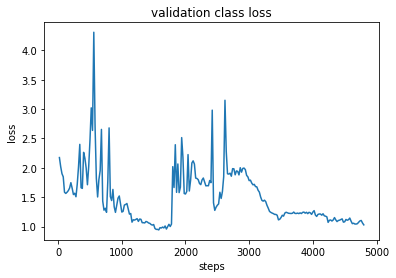

In [8]:
plt.title('validation class loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(steps, class_loss)

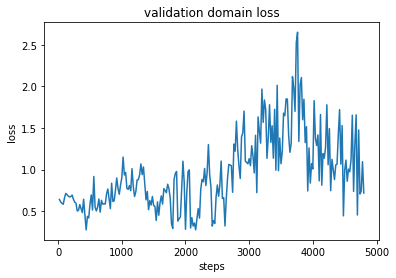

In [9]:
plt.title('validation domain loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(steps, domain_loss)

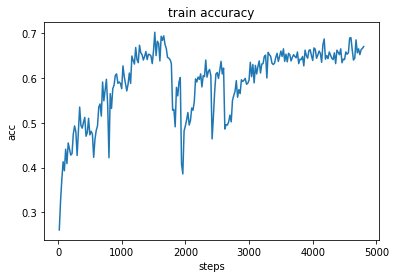

In [10]:
plt.title('train accuracy')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(steps, train_acc)

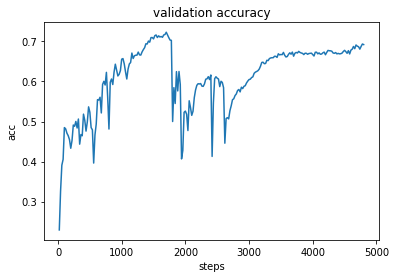

In [11]:
plt.title('validation accuracy')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(steps, val_acc)